In [49]:
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
from birds_utils import get_pytorch_model_all_conv, mp3_to_samples, Dataset, validate, multilabel_metrics, fix_corrupted_files, get_bin_audio, get_audio_chunk

In [13]:
SAMPLE_RATE = 22050
MODEL_FOLDER = Path('./models')
DATASET_FOLDER = Path('/home/usuario/birds/birdsong-recognition')
TARGET_FOLDER = f'./dataset/bin_{SAMPLE_RATE}_librosa/'

In [14]:
files_to_test = []
for file in glob(TARGET_FOLDER+'**/*', recursive=True):
    if '.bin' in file:
        files_to_test.append(file)
len(files_to_test)

5444

In [15]:
train = pd.read_csv(DATASET_FOLDER/'train.csv')

In [31]:
train['filename'][0]

'XC134874.mp3'

In [57]:
for N in range(11):
    file_to_test = files_to_test[N]
    audio = get_bin_audio(file_to_test)
    print(file_to_test, len(audio)/SAMPLE_RATE, train[train['filename'] == file_to_test.split('/')[-1].replace('.bin', '')]['duration'].values[0])

./dataset/bin_22050_librosa/rewbla/XC137775.mp3.bin 101.06403628117914 101
./dataset/bin_22050_librosa/rewbla/XC321249.mp3.bin 35.056326530612246 35
./dataset/bin_22050_librosa/rewbla/XC183592.mp3.bin 510.88802721088433 510
./dataset/bin_22050_librosa/rewbla/XC377142.mp3.bin 83.06403628117914 83
./dataset/bin_22050_librosa/rewbla/XC479928.mp3.bin 12.990068027210885 13
./dataset/bin_22050_librosa/rewbla/XC468997.mp3.bin 75.73006802721089 75
./dataset/bin_22050_librosa/rewbla/XC368448.mp3.bin 9.582902494331066 9
./dataset/bin_22050_librosa/rewbla/XC175375.mp3.bin 5.829115646258503 5
./dataset/bin_22050_librosa/rewbla/XC368449.mp3.bin 18.949024943310658 19
./dataset/bin_22050_librosa/rewbla/XC477976.mp3.bin 45.214557823129255 45
./dataset/bin_22050_librosa/rewbla/XC192591.mp3.bin 6.6 6


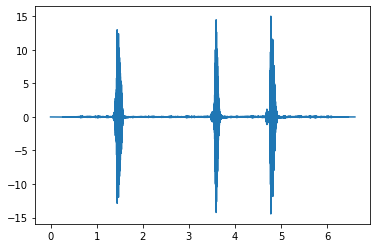

In [56]:
t = np.linspace(0, len(audio)/SAMPLE_RATE, len(audio))
plt.plot(t, audio)

ipd.Audio(audio, rate=SAMPLE_RATE)

In [77]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [78]:
window_size = 1024
model = get_pytorch_model_all_conv(window_size, resnet='resnet18', pretrained=True, n_classes=n_classes, init_fourier=True, train_fourier=False).to(device)

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [79]:
state_dict = torch.load('./models/model_ambient_264_0.67.pth', map_location=torch.device('cuda'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [80]:
classes = np.load('./models/classes_264.npy')
n_classes = len(classes)
std_stats = np.load('files_std_data_librosa.npy', allow_pickle=True).item()
duration = 5

In [81]:
val_files = np.load(f'val_files_{SAMPLE_RATE}_{n_classes}_librosa.npy')
val_labels = np.load(f'val_labels_{SAMPLE_RATE}_{n_classes}_librosa.npy')

In [82]:
N = 1
params_val = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0,
              'timeout': 0
             }
validation_set = Dataset(list(files_to_test)*N*2, classes, std_stats, chunk_seconds=duration, sr=SAMPLE_RATE, min_std=0.5, multilabel=True, add_noise=False, add_ambient_noise=False)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

In [83]:
criterion = torch.nn.BCEWithLogitsLoss()
validate(model, validation_generator, criterion, device)

RuntimeError: cuDNN error: CUDNN_STATUS_ALLOC_FAILED